#Installations

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !pip install pytorch-msssim
!pip install pytorch-msssim

#Imports



In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import torch
from datetime import datetime
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD, AdamW
# import optuna
# from optuna.pruners import MedianPruner
import json
import torchvision
import torch.nn.functional as F
import torch.nn
from torch.nn import Linear, ReLU, Softmax, Dropout, Sequential, Conv2d, MaxPool2d, Module, \
    BatchNorm2d, BatchNorm1d
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional
import PIL
import sys
import os
import time
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
from tqdm import tqdm_notebook
from torch.utils.data import random_split
from IPython.display import HTML
from torchsummary import summary
import logging
import threading
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#ssim loss
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


#settings + Hyperparams





In [ ]:
%matplotlib inline


num_epochs = 100


real_label = 1
fake_label = 0


# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 64



# Learning rate for optimizers
lrD = 0.0002
lrG = 0.0001


# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1




#Data Preprocessor + Dataloader

In [ ]:
import numpy as np
from PIL import Image


class PixelShift:

    def __init__(self, img_size=64):
        self.img_size = img_size
        self.alphabet = list(range(0, 256))
        self.func = np.array([np.array(self.alphabet[i:] + self.alphabet[:i]) for i in range(len(self.alphabet))])
        self.operator = self.gen_operator(size=img_size)
        self.operation_vec = np.vectorize(self.operation, otypes=[int])

    def operation(self, x1, x2):
        return self.func[x1, x2]

    def __call__(self, image, operator = None):
        operation = self.operator if operator is None else operator
        img = image
        not_np_arr = False
        if not (isinstance(img, np.ndarray)):
            img = np.array(image)
            not_np_arr = True
        img = self.operation_vec(img, operation)

        if not_np_arr:
            img = Image.fromarray(np.uint8(img)).convert('RGB')
        return img

    def gen_operator(self, size):
        operator = np.array([np.random.choice(self.alphabet, size=size) for x in range(size)])
        operator = np.stack((operator, operator, operator))
        operator = np.transpose(operator, axes=(1, 2, 0))

        return operator




# image = (image-mean) / std
mean = [0.5,0.5,0.5] #[0.4363, 0.4328, 0.3291]    # [0.485, 0.456, 0.406]
std = [0.5,0.5,0.5] #[0.2129, 0.2075, 0.2038]     # [0.229, 0.224, 0.225]  Source on mean and std: https://www.youtube.com/watch?v=z3kB3ISIPAg&t=20s


train_transform = transforms.Compose([
    transforms.Resize(224),    # to have the same average size to reduced to 224 to be trained faster, helps the model to generalize better
    # PixelShift(img_size = 224),
    # transforms.RandomHorizontalFlip(p=.40),   # the default is 50% probability: helps to solve issues like the angle problems in pictures taken
    # transforms.RandomRotation(30),
    transforms.ToTensor(),   # we need or make sure that everything is converted to a tensor
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])   # Normalization to help improving the performance (check if needed)

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])   # Normalization (check if needed)



# We follow the standard setting to use the 50k training images without labels for training


traindata = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=train_transform)
trainset,valset = random_split(traindata,[42000,8000])                  # Splitting the training data into train and validation datasets: to be adjusted for different used datasets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='.', train=False,download=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./cifar-10-python.tar.gz to .


#Discriminator

In [ ]:
# class block(nn.Module):

#   def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
#     super(block, self).__init__()
#     self.expansion           = 4
#     self.conv1               = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
#     self.bn1                 = nn.BatchNorm2d(out_channels)
#     self.conv2               = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#     self.bn2                 = nn.BatchNorm2d(out_channels)
#     self.conv3               = nn.Conv2d(out_channels, self.expansion*out_channels, kernel_size=1, stride=1, padding=0)
#     self.bn3                 = nn.BatchNorm2d(out_channels*self.expansion)
#     self.relu                = nn.ReLU(inplace = True)
#     self.identity_downsample = identity_downsample

#   def forward(self, x):

#     identity = x

#     x        = self.conv1(x)
#     x        = self.bn1(x)
#     x        = self.relu(x)

#     x        = self.conv2(x)
#     x        = self.bn2(x)
#     x        = self.relu(x)

#     x        = self.conv3(x)
#     x        = self.bn3(x)

#     if self.identity_downsample is not None:
#       identity = self.identity_downsample(identity)

#     x += identity
#     x = self.relu(x)

#     return x

# class ResNet(nn.Module):

#   def __init__(self, block, layers, image_channels, num_classes):
#     super(ResNet, self).__init__()
#     self.in_channels = 64
#     self.conv1       = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
#     self.bn1         = nn.BatchNorm2d(64)
#     self.relu        = nn.ReLU(inplace=True)
#     self.maxpool     = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#     # ResNet layers
#     self.layer1     = self._make_layer(block, layers[0], out_channels=64, stride=1)
#     self.layer2     = self._make_layer(block, layers[1], out_channels=128, stride=2)
#     self.layer3     = self._make_layer(block, layers[2], out_channels=256, stride=2)
#     self.layer4     = self._make_layer(block, layers[3], out_channels=512, stride=2)

#     self.avgpool    = nn.AdaptiveAvgPool2d((1,1))
#     self.fc         = nn.Linear(512*4, num_classes)
#     self.fc_activ   = nn.Sigmoid()

#   def forward(self, x):

#     x = self.conv1(x)
#     x = self.bn1(x)
#     x = self.relu(x)
#     x = self.maxpool(x)

#     x = self.layer1(x)
#     x = self.layer2(x)
#     x = self.layer3(x)
#     x = self.layer4(x)

#     x = self.avgpool(x)

#     x = x.reshape(x.shape[0], -1)

#     x = self.fc_activ(self.fc(x))

#     return x

#   def _make_layer(self, block, num_residual_blocks, out_channels, stride):

#     identity_downsample = None
#     layers              = []

#     if stride != 1 or self.in_channels != out_channels * 4:
#       identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels*4))

#     layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
#     self.in_channels = out_channels*4

#     for i in range(num_residual_blocks - 1):
#       layers.append(block(self.in_channels, out_channels))

#     return nn.Sequential(*layers)


#   def save_checkpoint(self, path, epoch, loss, optimizer):
#         torch.save({
#             'model_state_dict': self.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             'epoch': epoch,
#         }, path)

#   @staticmethod
#   def load_checkpoint(path):
#       return torch.load(path)

#   def save_model(self, path):
#       torch.save(self.state_dict(), path)
#       return path

#   @staticmethod
#   def load_model(path, type_=34, layers=(3, 4, 6, 3), num_classes=4000):
#       model = Resnet34()
#       if type_ == 50:
#           model = Resnet50()
    
#       model.load_state_dict(torch.load(path))
#       return model

#   @staticmethod
#   def initialize_weights(layer):
#       if type(layer) == Linear:
#           torch.nn.init.xavier_uniform_(layer.weight.data)
#           layer.bias.data.fill_(0.01)

# def ResNet50(img_channels=3, num_classes=1):

#   return ResNet(block, [3,4,6,3], img_channels, num_classes)




#Patch Extractor





In [ ]:

class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.
    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).
    patch_size : int
        Size of the patch (it is a square).
    in_chans : int
        Number of input channels.
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim


        # self.proj = nn.Conv2d(
        #         in_chans,
        #         embed_dim,
        #         kernel_size=patch_size,
        #         stride=patch_size,
        # )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        # x = self.proj(
        #         x
        #     )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        # x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        # x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        batch_size = x.shape[0]
        x = x.reshape(batch_size,self.n_patches,self.embed_dim)

        return x

#Attention Module

In [ ]:
class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.
    n_heads : int
        Number of attention heads.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    attn_p : float
        Dropout probability applied to the query, key and value tensors.
    proj_p : float
        Dropout probability applied to the output tensor.
    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """

    def __init__(self, dim, n_heads=10, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_patches, dim = x.shape

        if dim != self.dim:
            raise ValueError
       

        qkv = self.qkv(x)  # (n_samples, n_patches, 3 * dim)
        qkv = qkv.reshape(
            n_samples, n_patches, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches, 3, n_heads, head_dim)
        qkv = qkv.permute(
            2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches)
        dp = (
                     q @ k_t
             ) * self.scale  # (n_samples, n_heads, n_patches, n_patches)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches, n_patches)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches, head_dim)
        weighted_avg = weighted_avg.transpose(
            1, 2
        )  # (n_samples, n_patches , n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches , dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches , dim)
        x = self.proj_drop(x)  # (n_samples, n_patches, dim)

        return x

#MLP Module

In [ ]:
class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """

    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)

        return x


#Transformer Module

In [ ]:
class Transformer(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

#Encoder Module

In [ ]:
class Encoder(nn.Module):
    """
      Parameters
      ----------
      img_size : int
          Both height and the width of the image (it is a square).
      patch_size : int
          Both height and the width of the patch (it is a square).
      in_chans : int
          Number of input channels.
      compression_dim : int
          compression vector size.
      embed_dim : int
          Dimensionality of the token/patch embeddings.
      depth : int
          Number of blocks.
      n_heads : int
          Number of attention heads.
      mlp_ratio : float
          Determines the hidden dimension of the `MLP` module.
      qkv_bias : bool
          If True then we include bias to the query, key and value projections.
      p, attn_p : float
          Dropout probability.
      Attributes
      ----------
      patch_embed : PatchEmbed
          Instance of `PatchEmbed` layer.
      cls_token : nn.Parameter
          Learnable parameter that will represent the first token in the sequence.
          It has `embed_dim` elements.
      pos_emb : nn.Parameter
          Positional embedding of the cls token + all the patches.
          It has `(n_patches + 1) * embed_dim` elements.
      pos_drop : nn.Dropout
          Dropout layer.
      blocks : nn.ModuleList
          List of `Block` modules.
      norm : nn.LayerNorm
          Layer normalization.
      """

    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            compression_dim=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
    
    
        super().__init__()
    
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
            torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )
        
        self.pos_drop = nn.Dropout(p=p)
    
        self.blocks = nn.ModuleList(
            [
                Transformer(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )
    
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.fc = nn.Linear(embed_dim, compression_dim)

    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)
    
        cls_token = self.cls_token.expand(n_samples, -1, -1)  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)
    
        for block in self.blocks:
            x = block(x)
    
        x = self.norm(x)
    
        cls_token_final = x[:, 0]  # just the CLS token
        x = self.fc(cls_token_final)
    
        return x

#Decoder Module

In [ ]:
class Decoder(nn.Module):
    """
     Parameters
     ----------
     img_size : int
         Both height and the width of the image (it is a square).
    patch_size : int
        Both height and the width of the patch (it is a square).
     embed_dims : tuple
         Dimensionality of the token/patch embeddings.
     depth : int
         Number of blocks.
     n_heads : int
         Number of attention heads.
     mlp_sizes_list : tuple
         list of sizes for hidden layer and output layer of the MLP module in each transformer block
     qkv_bias : bool
         If True then we include bias to the query, key and value projections.
     p, attn_p : float
         Dropout probability.
    Attributes
    ---------
    blocks : nn.ModuleList
        List of `Block` modules.
    norm : nn.LayerNorm
        Layer normalization.
    """

    def __init__(
            self,
            img_size=224,
            in_chans=3,
            compression_dim=2000,
            depth=3,
            n_heads=10,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()
       

        self.image_size = img_size
        self.image_chnls = in_chans

        # self.blocks = nn.ModuleList(
        #     [
        #         Transformer(
        #             dim=compression_dim,
        #             n_heads=n_heads,
        #             mlp_ratio=mlp_ratio,
        #             qkv_bias=qkv_bias,
        #             p=p,
        #             attn_p=attn_p,
        #         )
        #         for i in range(depth)
        #     ]
        # )
        # self.fc0 = nn.Linear(compression_dim, compression_dim*2)
        # self.fc1 = nn.Linear(compression_dim*2, compression_dim*3)
        # self.fc2 = nn.Linear(compression_dim*3, compression_dim*4)
        self.norm = nn.LayerNorm(compression_dim , eps=1e-6)

        out_size = self.image_chnls * self.image_size*self.image_size
        self.fc = nn.Linear(compression_dim , out_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor - encoder output(compression) batch_size * compres_dim

          
        """

        # for block in self.blocks:
        #     x = block(x)

        x = self.fc(self.norm(x))

        # x = self.fc2(self.fc1(self.fc0(x)))
        # x = self.activation(self.fc(self.norm(x)))

        # batch_size, n_patches, embed_dim = x.shape
        batch_size = x.shape[0]
        x = torch.reshape(x, (batch_size, self.image_chnls, self.image_size, self.image_size))

        return x

#Generator

In [ ]:
class Generator(nn.Module):

    def __init__(self, img_size=224,
                 patch_size=16,
                 in_chans=3,
                 encoder_depth = 6,
                 decoder_depth = 3,
                 encoder_n_heads =12,
                 decoder_n_heads = 10,
                 compression_dim = 2000,
                 embed_dim = 768,
                 qkv_bias=True,
                 positional_encoding_dropout=0.1,
                 attn_dropout=0.1):
        super().__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans

        self.n_patches = (img_size // patch_size) ** 2
        self.out_size = int((img_size ** 2) * self.in_chans / self.n_patches)

        self.encoder = Encoder(
            img_size=self.img_size,
            patch_size=patch_size,
            in_chans=self.in_chans,
            compression_dim=compression_dim,
            embed_dim=embed_dim,
            depth=encoder_depth,
            n_heads=encoder_n_heads,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.
        )

      
        self.decoder = Decoder(
            img_size=self.img_size,
            in_chans=self.in_chans,
            compression_dim=compression_dim,
            depth=decoder_depth,
            n_heads= decoder_n_heads,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
        )

        


    def forward(self, x):
        x = self.encoder(x)
        compression = x
        # x = x.unsqueeze(1)
        x = self.decoder(x)

        return x, compression

    def save_checkpoint(self, path, epoch, loss, optimizer):
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'epoch': epoch,
        }, path)

    @staticmethod
    def load_checkpoint(path):
        return torch.load(path)

    def save_model(self, path):
        torch.save(self.state_dict(), path)
        return path

    @staticmethod
    def load_model(path, type_=34, layers=(3, 4, 6, 3), num_classes=4000):
        model = Resnet34()
        if type_ == 50:
            model = Resnet50()
     
        model.load_state_dict(torch.load(path))
        return model

    @staticmethod
    def initialize_weights(layer):
        if type(layer) == Linear:
            torch.nn.init.xavier_uniform_(layer.weight.data)
            layer.bias.data.fill_(0.01)

#Loss Functions

In [ ]:
def reconstruction_MSE(fake, real):
  return torch.mean((real - fake)**2)



def reconstruction_MAE(fake, real):
  return torch.mean(torch.abs(real - fake))

def reconstruction_BCE(fake, real):
     # reconstruction loss (pushing the points apart)
    x = torch.sigmoid(real)
    y = torch.sigmoid(fake)
    loss = -1*(x *torch.log(y) + (1- x) * torch.log(1-y))
    return  torch.mean(loss)


class reconstruction_SSIM:

  def gaussian(self,window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

  
  def create_window(self,window_size, n_channels=3):

      # Generate an 1D tensor containing values sampled from a gaussian distribution
      _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
      
      # Converting to 2D  
      _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
      
      window = torch.Tensor(_2d_window.expand(n_channels, 1, window_size, window_size).contiguous())

      return window


  def __call__(self,img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret



#Training Setup

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#models 
print("DISCRIMINATOR")
# netD=  ResNet50().to(device)
# for x in trainloader:
#   summary(netD, x[0].shape[1:])
#   break

# print("GENERATOR")
# netG = Generator().to(device)
# for x in trainloader:
#   summary(netG, x[0].shape[1:])
#   break

# #optimization
# optimizer_D = torch.optim.Adam(netD.parameters(), lr=lrD, betas=(0.5, 0.999))
# optimizer_G = torch.optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.999))
# # criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()

# # Lists to keep track of progress
# img_list = []
# G_losses = []
# D_losses = []
# iters = 0

DISCRIMINATOR


#HyperTuna

In [ ]:
# from collections import defaultdict
# import numpy as np
# import enum


# class DataTypes(enum.Enum):
#     INT = 0
#     FLOAT = 1
#     STR = 2
#     INT_LIST = 3
#     FLOAT_LIST = 4
#     STR_LIST = 5


# class Param:
#     def __init__(self, dtype=DataTypes.INT, learning_rate=0.005, update_probability=0.5, value_range: tuple = (-1, 1),
#                  fixed_range: bool = False,
#                  len_list=1):
#         self.dtype = dtype
#         self.len_list = len_list
#         self.value_range = value_range
#         self.fixed_range = fixed_range
#         self.value = None
#         self.learning_rate = learning_rate
#         self.update_probability = update_probability


# class Agent:
#     def __init__(self,
#                  params: dict,
#                  score_callback=None,
#                  int_learning_rate=0.1,
#                  float_learning_rate=0.001,
#                  str_update_probability=0.7):
#         self.ID = ''.join(np.random.choice(["A", "B", "C", "D", "E"] + [str(x) for x in range(10)], 5))
#         self.int_learning_rate = int_learning_rate
#         self.float_learning_rate = float_learning_rate
#         self.str_update_probability = str_update_probability
#         self.params = self.init_params(params)
#         self.score = None
#         self.score_callback = score_callback

#     def init_params(self, params):
#         parameters = defaultdict(lambda: Param)
#         for param_name in params.keys():
#             param = params[param_name]
#             parameters[param_name] = Param(dtype=param.dtype, value_range=param.value_range,
#                                            fixed_range=param.fixed_range)
#             if param.dtype == DataTypes.INT:
#                 parameters[param_name].value = self.init_INT_param(param.value_range)
#                 parameters[param_name].learning_rate = self.int_learning_rate
#             elif param.dtype == DataTypes.FLOAT:
#                 parameters[param_name].value = self.init_FLOAT_param(param.value_range)
#                 parameters[param_name].learning_rate = self.float_learning_rate
#             elif param.dtype == DataTypes.STR:
#                 parameters[param_name].value = np.random.choice(param.value_range)
#                 parameters[param_name].update_probability = self.str_update_probability
#             elif param.dtype == DataTypes.INT_LIST:
#                 parameters[param_name].value = self.init_INT_LIST_param(param.value_range,
#                                                                         param.len_list)
#                 parameters[param_name].learning_rate = self.int_learning_rate
#             elif param.dtype == DataTypes.FLOAT_LIST:
#                 parameters[param_name].value = self.init_FLOAT_LIST_param(param.value_range,
#                                                                           param.len_list)
#                 parameters[param_name].learning_rate = self.float_learning_rate
#             elif param.dtype == DataTypes.STR_LIST:
#                 parameters[param_name].value = self.init_STR_LIST_param(param.value_range,
#                                                                         param.len_list)
#                 parameters[param_name].update_probability = self.str_update_probability

#         return parameters

#     @staticmethod
#     def init_INT_param(value_range):
#         if len(value_range) == 2:
#             start = value_range[0]
#             end = value_range[1]
#             return np.random.randint(start, end)
#         elif len(value_range) > 2:
#             return np.random.choice(value_range)

#     @staticmethod
#     def init_FLOAT_param(value_range):
#         if len(value_range) == 2:
#             start = value_range[0]
#             end = value_range[1]
#             return np.random.uniform(start, end)
#         elif len(value_range) > 2:
#             return np.random.choice(value_range)

#     def init_INT_LIST_param(self, value_range, length):
#         return [
#             self.init_INT_param(value_range) for _ in range(length)
#         ]

#     def init_FLOAT_LIST_param(self, value_range, length):
#         return [
#             self.init_FLOAT_param(value_range) for _ in range(length)
#         ]

#     @staticmethod
#     def init_STR_LIST_param(value_range, length):
#         return [
#             np.random.choice(value_range) for _ in range(length)
#         ]

#     def update_params_(self, target):
#         for key in self.params.keys():
#             param = self.params[key]
#             target_param = target.params[key]
#             if param.dtype == DataTypes.INT:
#                 param.value = self.update_INT_param(param, target_param)
#             elif param.dtype == DataTypes.FLOAT:
#                 param.value = self.update_FLOAT_parma(param, target_param)
#             elif param.dtype == DataTypes.STR:
#                 param.value = self.update_STR_param(param, target_param)
#             elif param.dtype == DataTypes.INT_LIST:
#                 param.value = self.update_INT_LIST_param(param, target_param)
#             elif param.dtype == DataTypes.FLOAT_LIST:
#                 param.value = self.update_FLOAT_LIST_param(param, target_param)
#             elif param.dtype == DataTypes.STR_LIST:
#                 param.value = self.update_STR_LIST_param(param, target_param)

#     def update_INT_param(self, param, target):
#         val = param.value
#         if len(param.value_range) == 2:
#             val = param.value+ int((target.value - param.value) * param.learning_rate)
#             if (val > param.value_range[1] or val < param.value_range[0]) and param.fixed_range:
#                 val = param.value
#         elif len(param.value_range) > 2:
#             prob = np.random.uniform(0, 1)
#             val = target.value if prob > param.update_probability else param.value

#         return val

#     def update_FLOAT_parma(self, param, target):
#         val = param.value
#         if len(param.value_range) == 2:
#             val = param.value + (target.value - param.value) * param.learning_rate
#             if (val > param.value_range[1] or val < param.value_range[0]) and param.fixed_range:
#                 val = param.value
#         elif len(param.value_range) > 2:
#             prob = np.random.uniform(0, 1)
#             val = target.value if prob > param.update_probability else param.value

#         return val

#     def update_STR_param(self, param, target):
#         prob = np.random.uniform(0, 1)
#         return target.value if prob > param.update_probability else param.value

#     def update_INT_LIST_param(self, param, target):
#         if len(param.value_range) == 2:
#             return [
#                 int(
#                     (target.value[i] - param.value[i]) * param.learning_rate) for i in
#                 range(len(param.value))
#             ]
#         else:
#             probs = np.random.uniform(0, 1, size=len(param.value))
#             return [
#                 target.value[i] if probs[i] > param.update_probability else
#                 param.value[i]
#                 for i in range(len(param.value))
#             ]

#     def update_FLOAT_LIST_param(self, param, target):
#         if len(param.value_range) == 2:
#             return [
#                 (target.value[i] - param.value[i]) * param.learning_rate for i in
#                 range(len(param.value))
#             ]
#         else:
#             probs = np.random.uniform(0, 1, size=len(param.value))
#             return [
#                 target.value[i] if probs[i] > param.update_probability else
#                 param.value[i]
#                 for i in range(len(param.value))
#             ]

#     def update_STR_LIST_param(self, param, target):
#         probs = np.random.uniform(0, 1, size=len(param.value))
#         return [
#             target.value[i] if probs[i] > param.update_probability else
#             param.value[i]
#             for i in range(len(param.value))
#         ]

#     def report_score(self, score):
#         if self.score_callback is not None:
#             self.score_callback(self.ID, score)


In [ ]:



# class Optimizer:
#     def __init__(self, params_map, n_agents=1000):
#         self.SWARM_MIGRATION = "SWARM_MIGRATION"
#         self.ANNEALING = "SIMULATED ANNEALING"
#         self.MIXING_SWARM_MIGRATION = "MIXING_SWARM_MIGRATION"
#         self.OPTI_MAX = "MAX"
#         self.OPTI_MIN = "MIN"
#         self.SCORE_BOARD = defaultdict(lambda: [])
#         self.AGENTS = []

#         for n in range(n_agents):
#             self.AGENTS.append(Agent(params_map,
#                                      self.score_callback,
#                                      int_learning_rate=np.random.uniform(0.0001, 2),
#                                      float_learning_rate=np.random.uniform(0.0001, 2),
#                                      str_update_probability=np.random.uniform(0, 1)
#                                      ))

#         format = "%(asctime)s: %(message)s"
#         logging.basicConfig(format=format, level=logging.INFO,

#                             datefmt="%H:%M:%S")

#     def score_callback(self, agentID, score):
#         self.SCORE_BOARD[agentID].append(score)

#     def clear_score_board(self):
#         for xx in self.SCORE_BOARD.keys():
#             self.SCORE_BOARD[xx] = []

#     def run_trial(self, objective, agent, j):
#         logging.info(f"trial {j}: started")
#         agent.score = objective(agent)
#         logging.info(f"trial {j}: finished with score = {agent.score}")

#     def optimize(self,
#                  objective_function,
#                  evolution_function_name,
#                  optimization_type,
#                  n_runs,
#                  partition_size=1,
#                  verbose=True):

#         evolution_function = self.getEvolutionFunction(evolution_function_name)
#         agents = self.AGENTS.copy()
#         for i in range(n_runs):
#             logging.info("Run %s: started", i)
#             for j, agent in enumerate(agents):
#                 # run = threading.Thread(target=self.run_trial, args=(objective_function, agent,j))
#                 # run.start()
#                 # run.join()
#                 agent.score = objective_function(agent)
#             agents = evolution_function(agents, optimization_type, partition_size)
#             self.clear_score_board()
#             if verbose:
#                 objective_values = [agent.score for agent in agents]
#                 optimum_index = self.getOptimumIndex(objective_values, optimization_type)
#                 logging.info(f"Run{i} best score: {agents[optimum_index].score}")
#             logging.info("Run %s: finished", i)

#         objective_values = [agent.score for agent in agents]
#         optimum_index = self.getOptimumIndex(objective_values, optimization_type)
#         return agents[optimum_index]

#     def getEvolutionFunction(self, evolution_function_name):
#         if evolution_function_name == self.SWARM_MIGRATION:
#             return self.swarmMigration
#         if evolution_function_name == self.MIXING_SWARM_MIGRATION:
#             pass

#     def getOptimumIndex(self, objective_values, optimization_type):

#         """
#         :param objective_values:
#         :param optimization_type:
#         :return:
#         """
#         optimum_index = 0
#         if optimization_type == self.OPTI_MAX:
#             optimum_index = objective_values.index(max(objective_values))
#         elif optimization_type == self.OPTI_MIN:
#             optimum_index = objective_values.index(min(objective_values))

#         return optimum_index

#     def shuffle(self, *args):

#         """
#         :param args:
#         :return:
#         """
#         permutation = np.array(range(len(args[0])))
#         np.random.shuffle(permutation)

#         output = ()
#         for data_list in args:
#             new_data_list = []
#             for i in permutation:
#                 new_data_list.append(data_list[i])
#             output = output + (new_data_list,)

#         return output

#     def evolveSwarm(self, population_p, objective_values_p, optimization_type):

#         optimum_index = self.getOptimumIndex(objective_values_p, optimization_type)
#         optimum_agent = population_p[optimum_index]

#         for i, agent in enumerate(population_p):
#             if agent.ID != optimum_agent.ID:
#                 agent.update_params_(optimum_agent)

#         return population_p

#     def swarmMigration(self, population, optimization_type, partition_size):
#         """

#         :param population:
#         :param objective_values:
#         :param optimization_type:
#         :param learning_rate:
#         :param partition_size:
#         :return:
#         """

#         objective_values = [agent.score for agent in population]
#         # shuffle population and objective values
#         population, objective_values = self.shuffle(population, objective_values)

#         population_out = []
#         for n in range(len(population) // partition_size):
#             population_p = population[n * partition_size: (n + 1) * partition_size]
#             objective_values_p = objective_values[n * partition_size: (n + 1) * partition_size]
#             population_p = self.evolveSwarm(population_p, objective_values_p, optimization_type)
#             population_out = population_out + population_p

#         return population_out


#Generator Hyperparam Optim

In [ ]:
# class Trainer:

#     def __init__(self, params=None, n_epochs=10, experiment=False,
#                  opti_direction="minimize", pre_trained_path=None):
#         assert (params is not None) != experiment

#         self.IMG_SIZE = 224
#         self.experiment = experiment
#         self.load_pre_trained = pre_trained_path is not None and pre_trained_path != ""
#         self.pre_trained_path = pre_trained_path
#         self.params = params
#         self.n_epochs = n_epochs
#         self.batch_size = None

#         self.n_experiment_samples = 50
#         self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#         self.optimizer = None
#         self.lr = None
#         self.lr_decay = None
#         self.lr_scheduler = None
#         self.weight_decay = None

#         self.model = None
#         self.train_loader = None
#         self.valid_loader = None
#         self.optimization_direction = opti_direction

#     def __call__(self):
#         if self.experiment:
#             params_map = {
#                 "batch_size": Param(dtype=DataTypes.INT, value_range=(32, 100),fixed_range=True),
#                 "patch_size": Param(dtype=DataTypes.INT, value_range=(14,16)),
#                 "encoder_n_heads": Param(dtype=DataTypes.INT, value_range=(5,5, 10,10)),
#                 "decoder_n_heads": Param(dtype=DataTypes.INT, value_range=(5,5, 10,10)),
#                 "pos_enc_drp": Param(dtype=DataTypes.FLOAT, value_range=(0.0, 0.9),fixed_range=True),
#                 "attn_blk_drp": Param(dtype=DataTypes.FLOAT, value_range=(0.0, 0.9),fixed_range=True),
#                 "optimizer": Param(dtype=DataTypes.STR, value_range=("SGD", "Adam", "RMSprop")),
#                 "lr": Param(dtype=DataTypes.FLOAT, value_range=(1e-7, 1e-1),fixed_range=True),
#                 "weight_decay": Param(dtype=DataTypes.FLOAT, value_range=(1e-6, 1.0),fixed_range=True),
#                 "lr_decay": Param(dtype=DataTypes.FLOAT, value_range=(0.01, 0.95), fixed_range=True),
#             }
            
#             hyper_tuna = Optimizer(params_map=params_map, n_agents=500)
#             best_trial = hyper_tuna.optimize(
#                 objective_function=self.objective,
#                 evolution_function_name=hyper_tuna.SWARM_MIGRATION,
#                 optimization_type=hyper_tuna.OPTI_MIN if self.optimization_direction == "minimize" else hyper_tuna.OPTI_MAX,
#                 n_runs=100,
#                 partition_size=5,
#                 verbose=True
#             )
#             print("Best Params:")
#             for key in best_trial.params.keys():
#               print(f"    {key} : {best_trial.params[key].value}")

#         else:
#             self.objective()

#         return

#     def init_experiment(self, trial):
#         # data
#         self.batch_size = trial.params["batch_size"].value
#         self.train_loader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=False)
#         self.valid_loader = torch.utils.data.DataLoader(valset, batch_size=self.batch_size, shuffle=False)

#         # model architecture
#         patch_size = trial.params["patch_size"].value
#         encoder_n_heads = trial.params["encoder_n_heads"].value
#         decoder_n_heads = trial.params["decoder_n_heads"].value

#         positional_encoding_dropout = trial.params["pos_enc_drp"].value
#         attn_dropout = trial.params["attn_blk_drp"].value

#         torch.manual_seed(0.0)
#         self.model = Generator(img_size=224,
#                                patch_size=patch_size,
#                                in_chans=3,
#                                encoder_embed_dims=(1000, 500, 200, 100),
#                                decoder_embed_dims=(50, 100, 200, 500),
#                                encoder_depth=4,
#                                decoder_depth=4,
#                                encoder_n_heads=encoder_n_heads,
#                                decoder_n_heads=decoder_n_heads,
#                                encoder_mlp_sizes_list=((900, 500), (400, 200), (200, 100), (100, 50)),
#                                decoder_mlp_sizes_list=((100, 100), (100, 200), (200, 500), (500, 500)),
#                                qkv_bias=True,
#                                positional_encoding_dropout=positional_encoding_dropout,
#                                attn_dropout=attn_dropout).to(self.device)

#         optimizer_name = trial.params["optimizer"].value
#         self.lr = trial.params["lr"].value
#         self.weight_decay = trial.params["weight_decay"].value
#         self.optimizer = getattr(optim, optimizer_name)(self.model.parameters(), lr=self.lr,
#                                                         weight_decay=self.weight_decay)
#         self.lr_decay = trial.params["lr_decay"].value

#     def init_training(self):
#         pass

#     def objective(self, trial=None):

#         if self.experiment:
#             self.init_experiment(trial=trial)
#         else:
#             self.init_training()

#         self.lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=self.optimizer, mode='min',
#                                                                  factor=self.lr_decay, patience=5,
#                                                                  threshold=0.0001, threshold_mode='rel', cooldown=0,
#                                                                  min_lr=0,
#                                                                  eps=1e-08, verbose=False)

#         for epoch in range(self.n_epochs):
#             # Training
#             loss_hist = []
#             self.model.train()
#             for i, (feats, labels) in enumerate(self.train_loader):
#                 self.model.zero_grad()
#                 if self.experiment and i * self.batch_size >= self.n_experiment_samples:
#                     break
#                 feats = feats.to(self.device).float()
#                 output, _ = self.model(feats)
#                 loss = reconstruction_MAE(feats, output)
#                 loss_hist.append(loss.item())
#                 loss.backward()
#                 self.optimizer.step()

#                 del feats
#                 del labels
#                 del loss
#                 torch.cuda.empty_cache()

#             # Validation.
            
#             val_loss_hist = []
#             with torch.no_grad():
#                 self.model.eval()
#                 for i, (feats, labels) in enumerate(self.valid_loader):
#                     if self.experiment and i * self.batch_size >= self.n_experiment_samples//2 : break
#                     feats = feats.to(self.device).float()
#                     output, _ = self.model(feats)
#                     val_loss = reconstruction_MAE(feats, output)
#                     val_loss_hist.append(val_loss.item())

#                     del feats
#                     del labels
#                     torch.cuda.empty_cache()

#             mean_val_loss = np.mean(val_loss_hist)
#             self.lr_scheduler.step(mean_val_loss)
#             if epoch % 1 == 0:pass
#                 # print(f"epoch {epoch} Tloss = {np.mean(loss_hist)}  Vloss = {mean_val_loss}")
#             if self.experiment:
#                 trial.report_score(mean_val_loss)

#         return mean_val_loss


# if __name__ == "__main__":
#     EPOCHS = 5
#     EXPERIMENT = True
#     PRE_TRAINED_PATH = ""

#     if EXPERIMENT:
#         Trainer(n_epochs=EPOCHS, experiment=EXPERIMENT)()

#Train  Generator


Epoch 0 Loss =  0.3565400214681524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


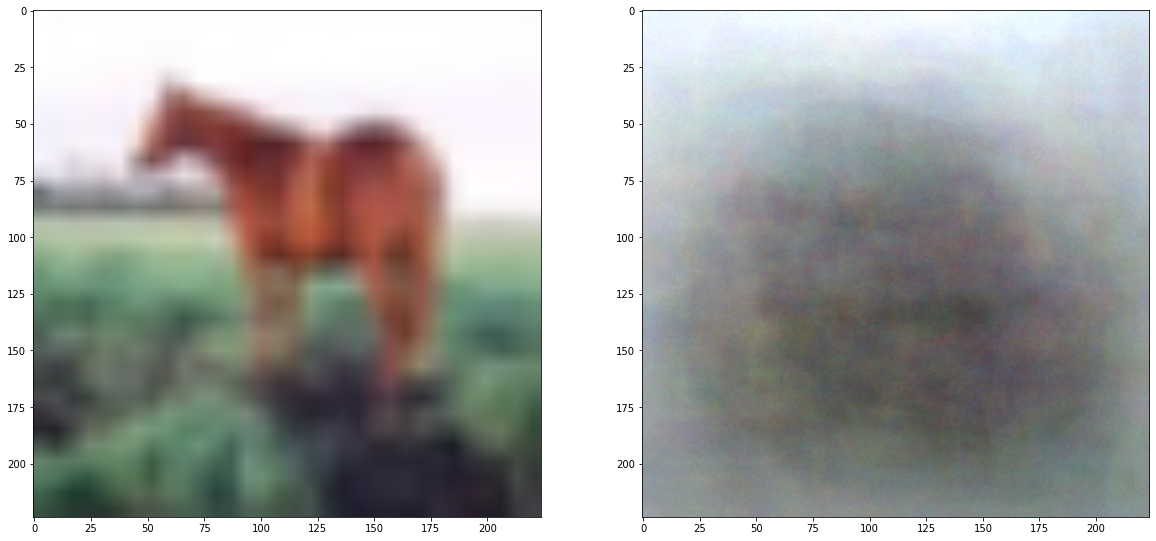

Epoch 1 Loss =  0.31453813510398343
Epoch 2 Loss =  0.2980483826618398
Epoch 3 Loss =  0.27772275042043976
Epoch 4 Loss =  0.2619766204460571
Epoch 5 Loss =  0.24206464720643275
Epoch 6 Loss =  0.22201332495274245
Epoch 7 Loss =  0.20675743367846153
Epoch 8 Loss =  0.19434370479264398
Epoch 9 Loss =  0.18485812142015048
Epoch 10 Loss =  0.17777712044378394


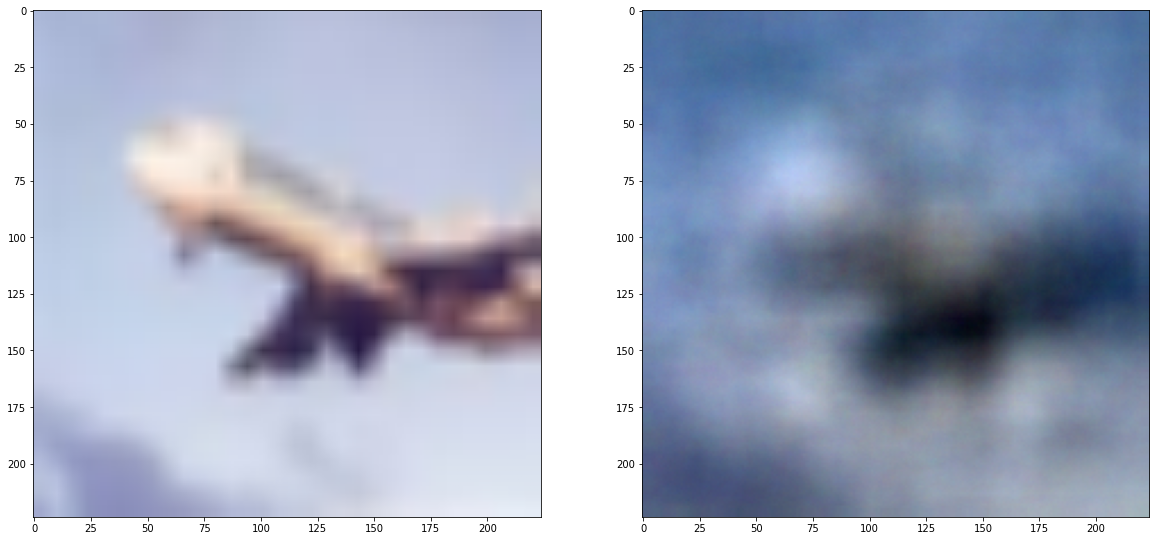

Epoch 11 Loss =  0.171798463349473
Epoch 12 Loss =  0.16641427395097017
Epoch 13 Loss =  0.1605658467910061
Epoch 14 Loss =  0.1551498580650289
Epoch 15 Loss =  0.1501097333032065
Epoch 16 Loss =  0.14555706829966658
Epoch 17 Loss =  0.1412780167849641
Epoch 18 Loss =  0.13718540206710317
Epoch 19 Loss =  0.13336028429698002
Epoch 20 Loss =  0.1296245953808092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


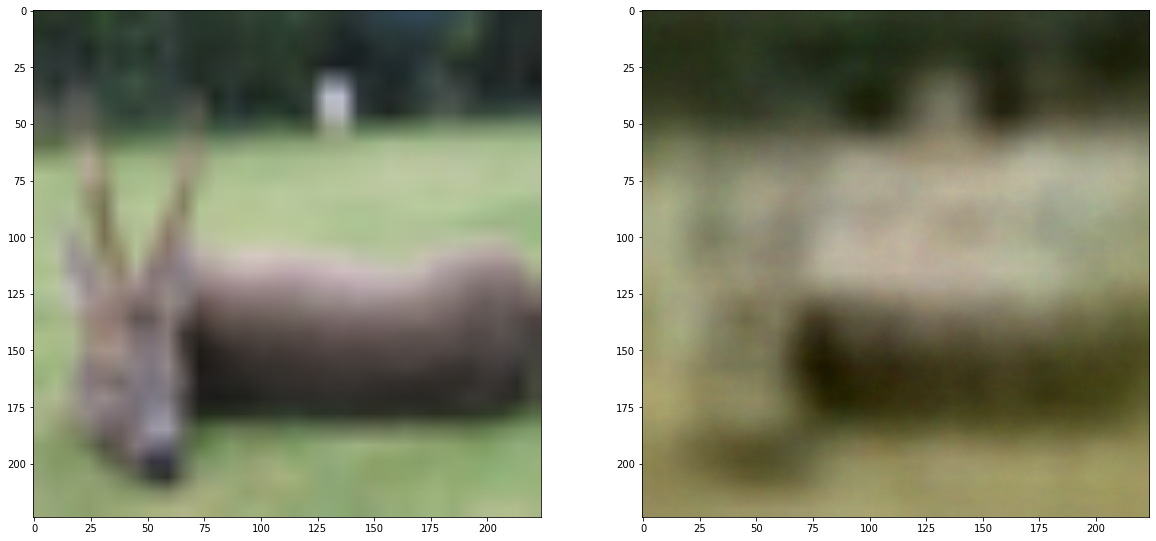

Epoch 21 Loss =  0.1265451964926502
Epoch 22 Loss =  0.12369348851558462
Epoch 23 Loss =  0.12052079460256176
Epoch 24 Loss =  0.1180265978931292
Epoch 25 Loss =  0.11558444709538325
Epoch 26 Loss =  0.11297317776868696
Epoch 27 Loss =  0.11112446650930735
Epoch 28 Loss =  0.10891659400189123
Epoch 29 Loss =  0.10709064746420133
Epoch 30 Loss =  0.10507076531875442


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


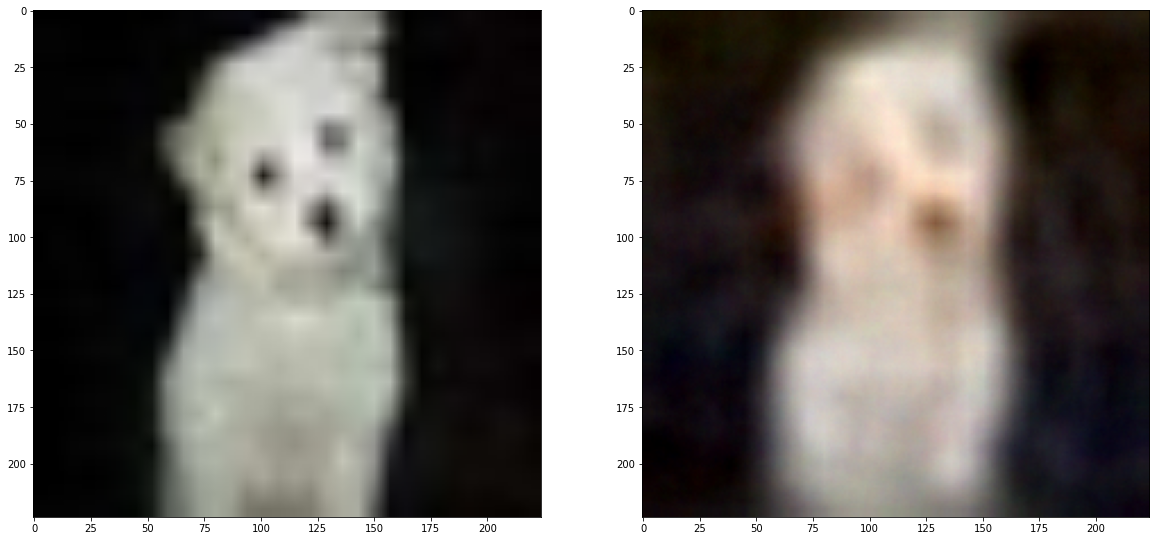

Epoch 31 Loss =  0.10332473288070484
Epoch 32 Loss =  0.10149609324730695
Epoch 33 Loss =  0.10014377289438901
Epoch 34 Loss =  0.09893443743886832
Epoch 35 Loss =  0.09754133250570007
Epoch 36 Loss =  0.09631364079280168
Epoch 37 Loss =  0.09525845722611455
Epoch 38 Loss =  0.09398417029660223
Epoch 39 Loss =  0.09290166031370788
Epoch 40 Loss =  0.09184437084098203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


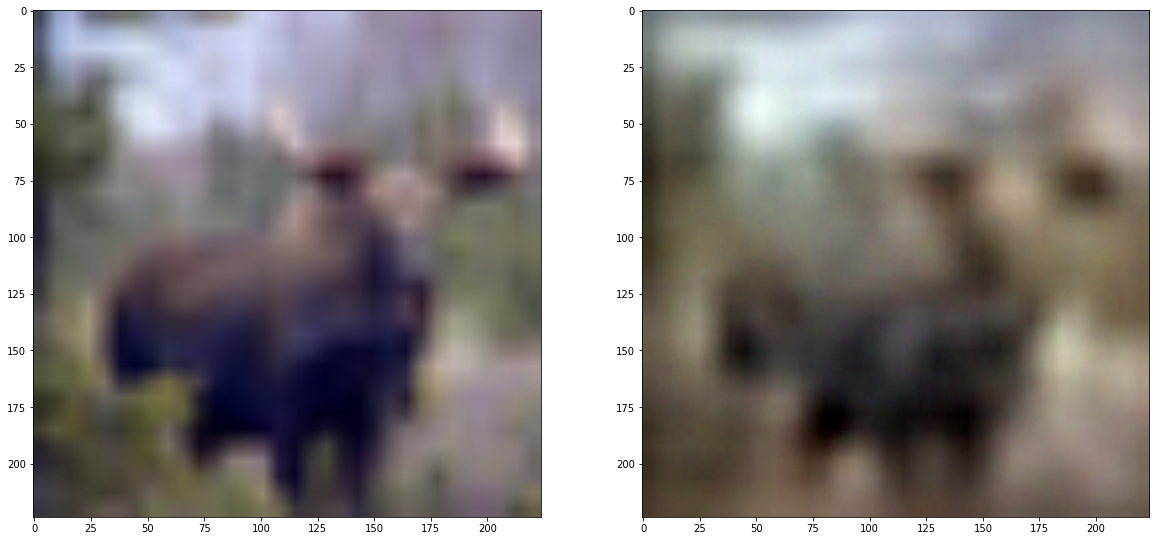

Epoch 41 Loss =  0.09113059162277065
Epoch 42 Loss =  0.090089084407601
Epoch 43 Loss =  0.08945145603138925
Epoch 44 Loss =  0.08826657493500949
Epoch 45 Loss =  0.08750881292096012
Epoch 46 Loss =  0.08687548672771889
Epoch 47 Loss =  0.08618688401929138
Epoch 48 Loss =  0.0855954834224608
Epoch 49 Loss =  0.08479928977141098
Epoch 50 Loss =  0.08412672438668696


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


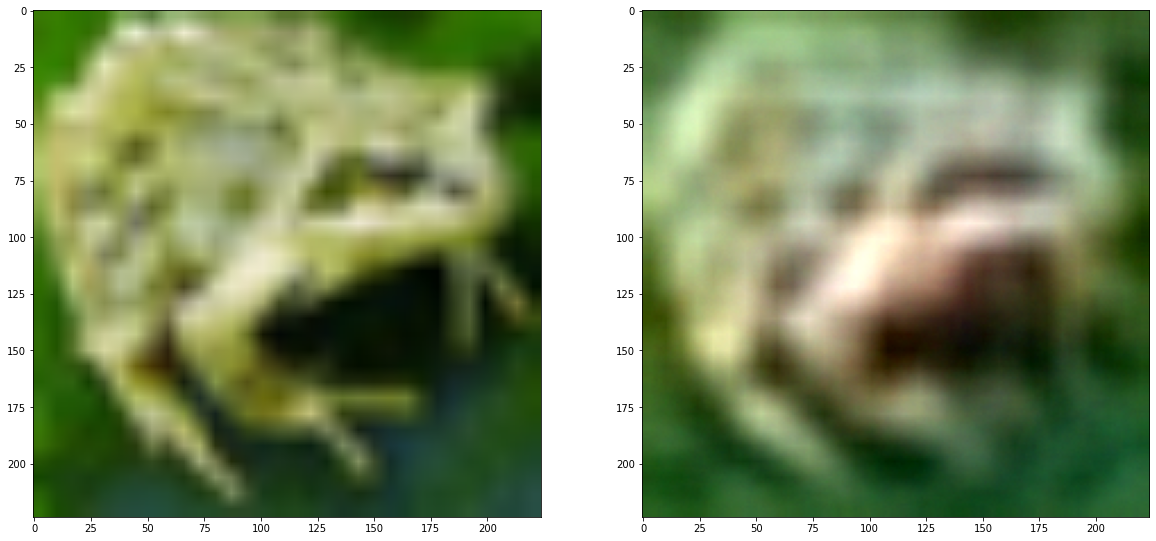

Epoch 51 Loss =  0.08346422271777505
Epoch 52 Loss =  0.08292122981319688
Epoch 53 Loss =  0.08230674647849444
Epoch 54 Loss =  0.0816598650935578
Epoch 55 Loss =  0.08119291745273671
Epoch 56 Loss =  0.08086921911987177
Epoch 57 Loss =  0.08021644242051167
Epoch 58 Loss =  0.07963821018622165
Epoch 59 Loss =  0.07936122884216919
Epoch 60 Loss =  0.07867314748159826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


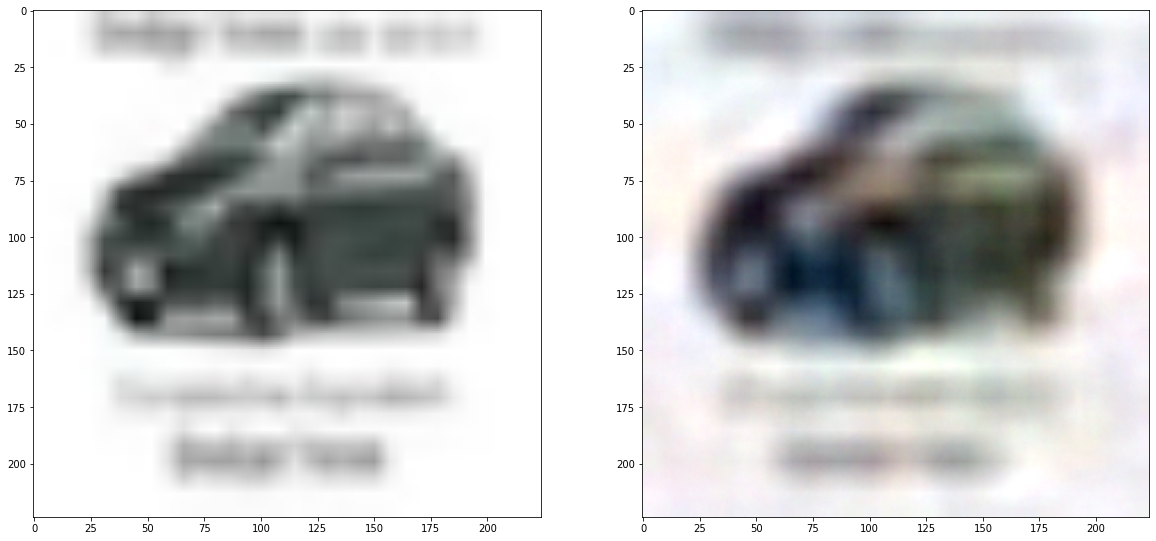

Epoch 61 Loss =  0.07834811334014846
Epoch 62 Loss =  0.07783845036405407
Epoch 63 Loss =  0.0774745906347372
Epoch 64 Loss =  0.07698571974556195
Epoch 65 Loss =  0.0766895345923926
Epoch 66 Loss =  0.07621784620497325
Epoch 67 Loss =  0.07577351439897329
Epoch 68 Loss =  0.07544469625846437
Epoch 69 Loss =  0.07503742085063839
Epoch 70 Loss =  0.07450438913417189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


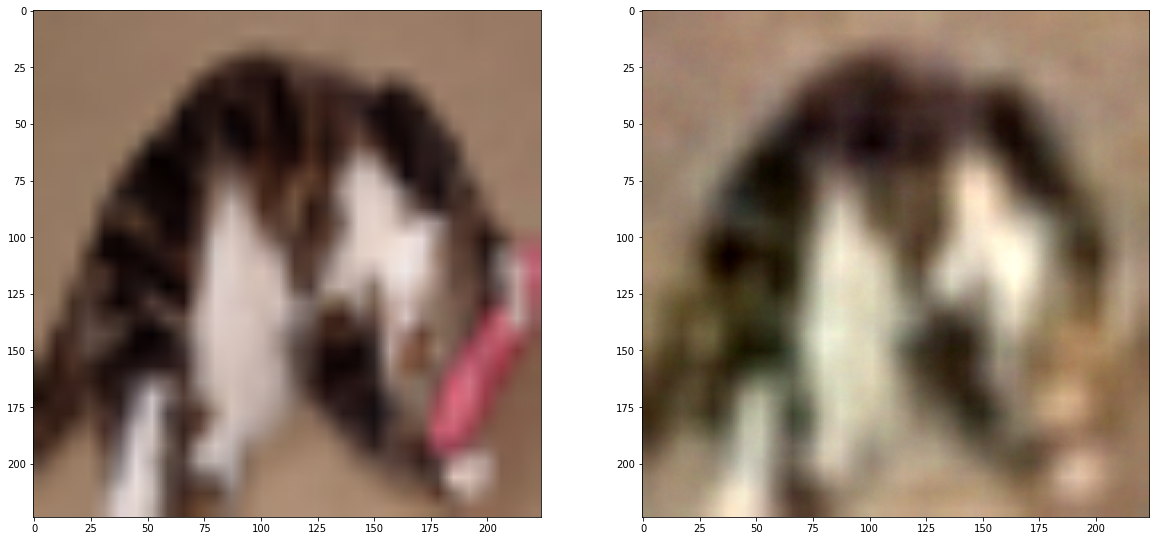

Epoch 71 Loss =  0.07437047546040522
Epoch 71 Loss =  0.07437047546040522
Epoch 72 Loss =  0.0738287727537039
Epoch 72 Loss =  0.0738287727537039
Epoch 73 Loss =  0.0736980856236076
Epoch 73 Loss =  0.0736980856236076
Epoch 74 Loss =  0.0733997983067003
Epoch 74 Loss =  0.0733997983067003
Epoch 75 Loss =  0.07290804445108504
Epoch 75 Loss =  0.07290804445108504
Epoch 76 Loss =  0.0729258371066285
Epoch 76 Loss =  0.0729258371066285
Epoch 77 Loss =  0.0720833681489779
Epoch 77 Loss =  0.0720833681489779
Epoch 78 Loss =  0.07180364899439355
Epoch 78 Loss =  0.07180364899439355
Epoch 79 Loss =  0.07124220535635403
Epoch 79 Loss =  0.07124220535635403
Epoch 80 Loss =  0.0709117255095659
Epoch 80 Loss =  0.0709117255095659


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


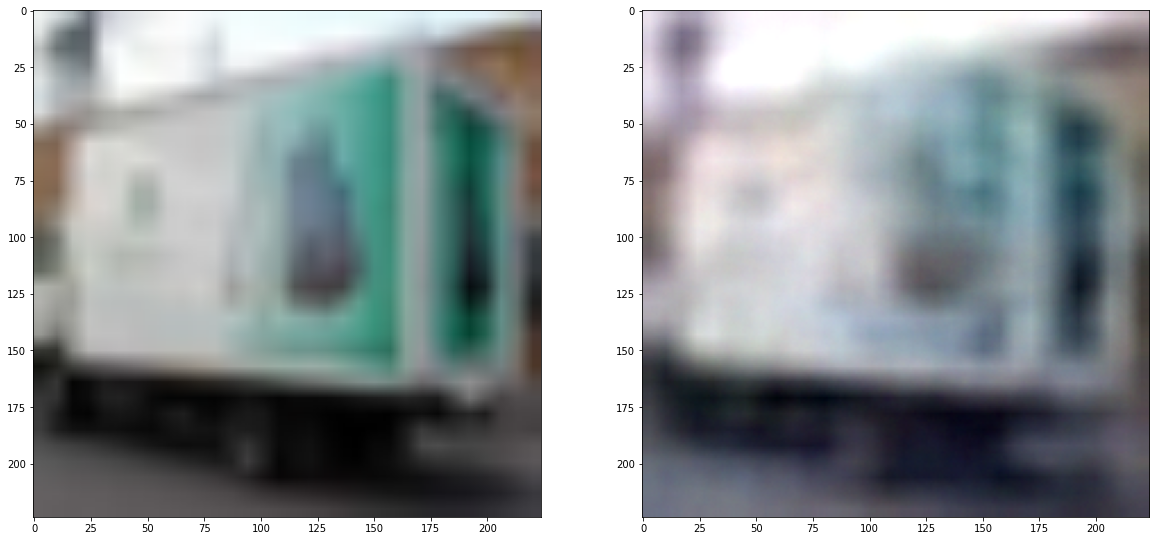

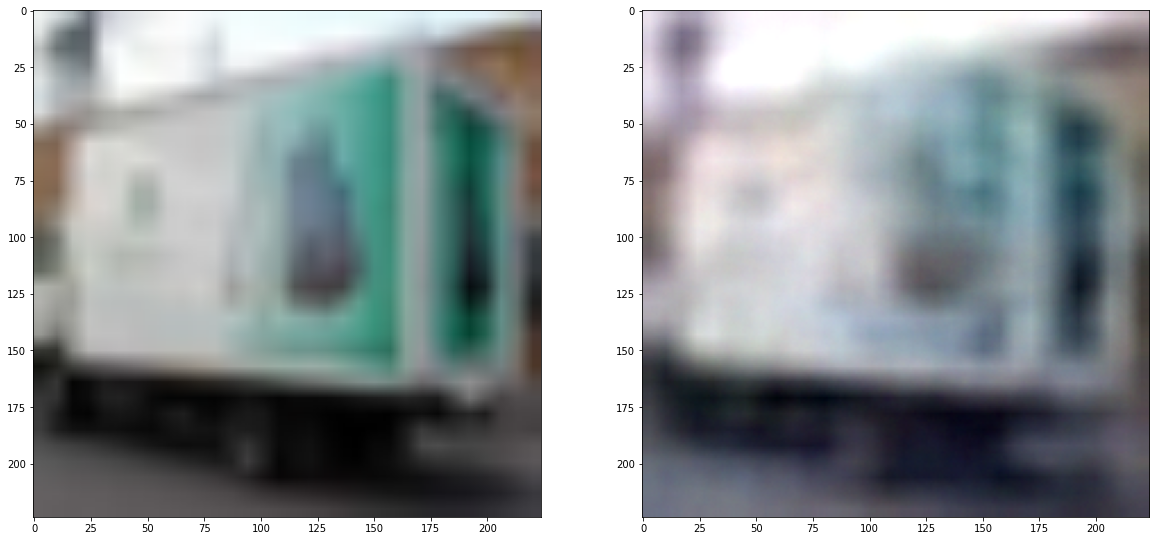

Epoch 81 Loss =  0.07078292666504916
Epoch 81 Loss =  0.07078292666504916
Epoch 82 Loss =  0.0703986516191172
Epoch 82 Loss =  0.0703986516191172
Epoch 83 Loss =  0.06984446980229252
Epoch 83 Loss =  0.06984446980229252
Epoch 84 Loss =  0.0698448846079806
Epoch 84 Loss =  0.0698448846079806
Epoch 85 Loss =  0.06944956283455025
Epoch 85 Loss =  0.06944956283455025
Epoch 86 Loss =  0.06929416096056251
Epoch 86 Loss =  0.06929416096056251
Epoch 87 Loss =  0.0688799225315565
Epoch 87 Loss =  0.0688799225315565
Epoch 88 Loss =  0.06871282749864609
Epoch 88 Loss =  0.06871282749864609
Epoch 89 Loss =  0.06843067130677777
Epoch 89 Loss =  0.06843067130677777
Epoch 90 Loss =  0.06797668042407007
Epoch 90 Loss =  0.06797668042407007


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


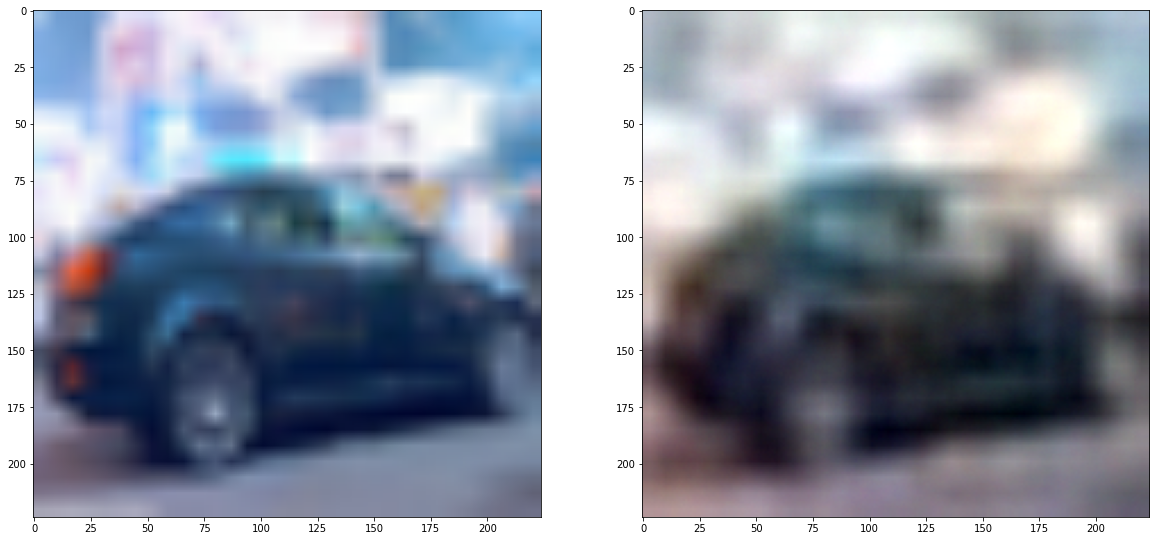

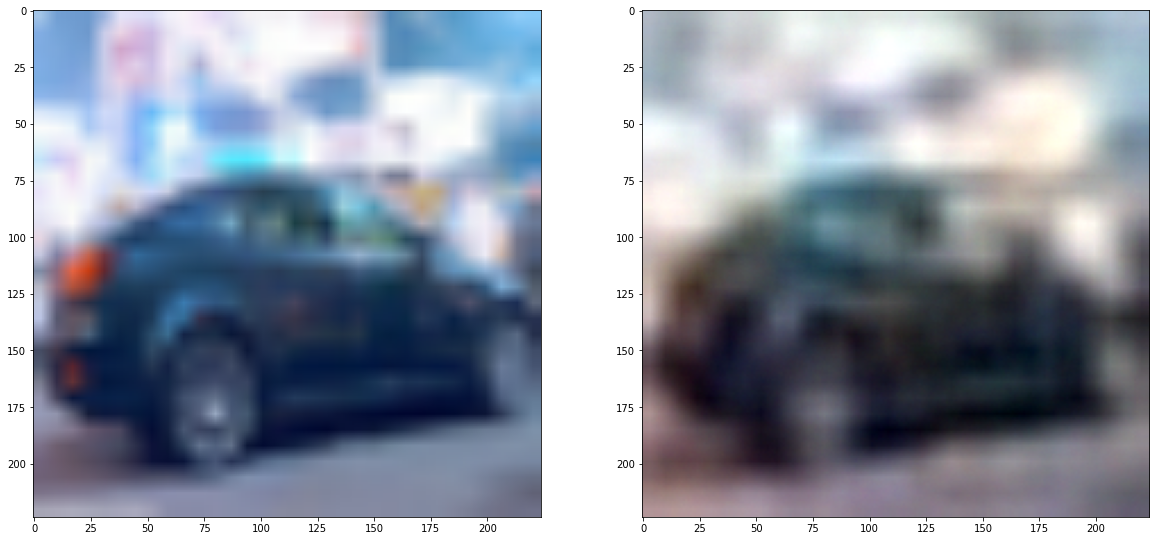

Epoch 91 Loss =  0.06772687365520672
Epoch 91 Loss =  0.06772687365520672


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
optimizer_G = torch.optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.999), weight_decay=5e-6)
# optimizer_G = torch.optim.SGD(netG.parameters(), lr=lrG, weight_decay=5e-6)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_G, mode='min',
                                                                 factor=0.5, patience=4,
                                                                 threshold=0.0001, threshold_mode='rel', cooldown=0,
                                                                 min_lr=0,
                                                                 eps=1e-08, verbose=True)


for epoch in range(num_epochs):
    
    netG.train()
    epoch_loss = []
    for  i, (x_data, y_data) in enumerate(trainloader):# For each batch in the dataloader
        # if i *batch_size > 2000: break
        netG.zero_grad()
        real_features = x_data.to(device).float()

        fake,_ = netG(real_features)
        err =  reconstruction_MAE(fake,real_features) #+ reconstruction_BCE(fake,real_features)
        err.backward()
        optimizer_G.step()
        epoch_loss.append(err.item())
        # print(torch.min(real_features), torch.max(real_features))
        # print(torch.min(fake), torch.max(fake))
        # print("_________________")

        del real_features
        del fake
        del err
        torch.cuda.empty_cache()

       
        
    # Output training stats
    print(f"Epoch {epoch} Loss = ",np.mean(epoch_loss))
    lr_scheduler.step(np.mean(epoch_loss))


    if epoch % 10 == 0:
      netG.eval()
      with torch.no_grad():
        for  i, (x_data, y_data) in enumerate(valloader):
          real_features = x_data.to(device).float()
          x = real_features[10].cpu().detach().numpy()
          x = (x + 1)/2
          x = np.transpose(x, [1,2,0])

          fake,_ = netG(real_features)
          y = fake[10].cpu().detach().numpy()
          y = (y + 1)/2
          y = np.transpose(y, [1,2,0])


          fig, axes = plt.subplots(1,2,figsize=(20, 15))
          axes[0].imshow(x)
          axes[1].imshow(y)
          plt.show()

          del real_features
          del fake
          del x
          del y
          torch.cuda.empty_cache()

          break
        


#Main Training Loop

In [ ]:
print("Starting Training Loop...")
import time



# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for  i, (x_data, y_data) in enumerate(trainloader):
       
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ##########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_features = x_data.to(device).float()
        # print(torch.min(real_features).item(), torch.max(real_features).item())
        
        
        batch_size = real_features.size(0)

        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device).unsqueeze(1)
       
        # label = torch.full((batch_size,), real_label, device=device).float().unsqueeze(1)
        # Forward pass real batch through D

        output = netD(real_features)
        
  
        # Calculate loss on all-real batch
        errD_real = criterion(output, label) 
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = real_features   # original images to be compressed
        # Generate fake image batch with G
        fake,compression = netG(noise)
        # print(torch.min(fake).item(), torch.max(fake).item())
        label.fill_(fake_label).unsqueeze(1)
        # Classify all fake batch with D
        output = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)  
        # Calculate the gradients for this batch
        errD_fake.backward()

        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake 
       
        # Update D
        optimizer_D.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, label) + reconstruction_MSE(real_features,fake)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_G.step()
        

        # Output training stats
        if i % 2 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())


        iters += 1
    # netD.save_model('./netD')
    # netG.save_model('./netG')

#Experiment Notes


Training a generator using reconstruction error:

  **Results + observations**
  lr = 0.00002